<a href="https://colab.research.google.com/github/CaoHung42/Wheat_Detection/blob/main/YoloV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 28 17:39:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection

/content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection


In [6]:
!pwd

/content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection


In [7]:
!gdown --id 1wsJCU9Sqf0Or8XHdVBRSMZU3otzLkk1x

Downloading...
From: https://drive.google.com/uc?id=1wsJCU9Sqf0Or8XHdVBRSMZU3otzLkk1x
To: /content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection/global-wheat-detection.zip
637MB [00:04, 133MB/s]


In [8]:
!unzip global-wheat-detection.zip

Archive:  global-wheat-detection.zip
  inflating: sample_submission.csv   
  inflating: test/2fd875eaa.jpg      
  inflating: test/348a992bb.jpg      
  inflating: test/51b3e36ab.jpg      
  inflating: test/51f1be19e.jpg      
  inflating: test/53f253011.jpg      
  inflating: test/796707dd7.jpg      
  inflating: test/aac893a91.jpg      
  inflating: test/cb8d261a3.jpg      
  inflating: test/cc3532ff6.jpg      
  inflating: test/f5a1f0358.jpg      
  inflating: train.csv               
  inflating: train/00333207f.jpg     
  inflating: train/005b0d8bb.jpg     
  inflating: train/006a994f7.jpg     
  inflating: train/00764ad5d.jpg     
  inflating: train/00b5c6764.jpg     
  inflating: train/00b5fefed.jpg     
  inflating: train/00b70a919.jpg     
  inflating: train/00e903abe.jpg     
  inflating: train/00ea5e5ee.jpg     
  inflating: train/010b216d4.jpg     
  inflating: train/010c93b99.jpg     
  inflating: train/010dbcc8f.jpg     
  inflating: train/0114c88aa.jpg     
  inflating: 

In [9]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 7659, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 7659 (delta 237), reused 282 (delta 195), pack-reused 7280
Receiving objects: 100% (7659/7659), 9.07 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (5253/5253), done.


In [10]:
%cd yolov5

/content/drive/My Drive/Colab Notebooks/GlobalWheetDetection/yolov5


In [11]:
!ls

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  tutorial.ipynb
data		 export.py   models	test.py		  utils
detect.py	 hubconf.py  README.md	train.py


In [12]:
!pip install -r requirements.txt
#cài thư viện

     |████████████████████████████████| 645kB 7.9MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [13]:
!bash data/scripts/download_weights.sh
#Tải weight

100% 14.1M/14.1M [00:00<00:00, 85.6MB/s]

100% 41.1M/41.1M [00:00<00:00, 85.3MB/s]

100% 90.2M/90.2M [00:01<00:00, 85.2MB/s]

100% 168M/168M [00:02<00:00, 75.3MB/s]



In [14]:
!ls

CONTRIBUTING.md  export.py   README.md	       tutorial.ipynb  yolov5s.pt
data		 hubconf.py  requirements.txt  utils	       yolov5x.pt
detect.py	 LICENSE     test.py	       yolov5l.pt
Dockerfile	 models      train.py	       yolov5m.pt


Convert bounding box to Yolo format

In [15]:
%cd ..

/content/drive/My Drive/Colab Notebooks/GlobalWheetDetection


In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
import glob
from PIL import Image
import cv2
from tqdm.auto import tqdm
import os
import shutil

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu

In [23]:
# Setup the paths to train and test images
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection/train/'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection/test/'
TRAIN_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/GlobalWheetDetection/train.csv'

# Glob the directories and get the lists of train and test images
train_fns = glob.glob(TRAIN_DIR + '*')
test_fns = glob.glob(TEST_DIR + '*')

In [24]:
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 3422
Number of test images is 10


In [25]:
df = pd.read_csv(TRAIN_CSV_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB


In [26]:
df[['width', 'height']].value_counts()

width  height
1024   1024      147793
dtype: int64

In [27]:
# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(df, on='image_id', how='left')
# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')
# splitbbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [28]:
all_train_images.head()

,image_id,width,height,bbox,source,bbox_xmin,bbox_ymin,bbox_width,bbox_height
0,00333207f,1024.0,1024.0,"[0, 654, 37, 111]",arvalis_1,0.0,654.0,37.0,111.0
1,00333207f,1024.0,1024.0,"[0, 817, 135, 98]",arvalis_1,0.0,817.0,135.0,98.0
2,00333207f,1024.0,1024.0,"[0, 192, 22, 81]",arvalis_1,0.0,192.0,22.0,81.0
3,00333207f,1024.0,1024.0,"[4, 342, 63, 38]",arvalis_1,4.0,342.0,63.0,38.0
4,00333207f,1024.0,1024.0,"[82, 334, 82, 81]",arvalis_1,82.0,334.0,82.0,81.0


In [29]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
    return bboxes

In [30]:
def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].imshow(img)       
            bboxes = get_all_bboxes(df, img_id)
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)       
            axs[row, col].axis('off')       
    plt.suptitle(title)

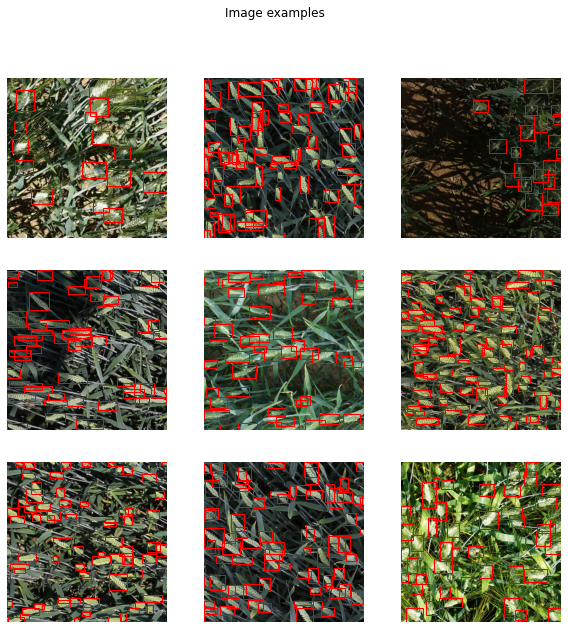

In [31]:
plot_image_examples(all_train_images)

In [32]:
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [33]:
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


In [34]:
def splitData(data =df, source='train'):
  index = list(set(df.image_id))
  for fold in [0]:
      val_index = index[len(index) * fold // 5: len(index) * (fold + 1) //5]
      for name, mini in tqdm(df.groupby('image_id')):
          if name in val_index:
              path2save = 'val/'
          else:
              path2save = 'train/'
          if not os.path.exists('convertor/fold{}/labels/'.format(fold) + path2save):
              os.makedirs('convertor/fold{}/labels/'.format(fold) + path2save)
          with open('convertor/fold{}/labels/'.format(fold) + path2save + name + ".txt", 'w') as f:
              row = mini[['classes','x_center','y_center','w','h']].astype(float).values
              row = row / 1024
              row = row.astype(str)
              for j in range(len(row)):
                  text = ' '.join(row[j])
                  f.write(text)
                  f.write("\n")
          if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
              os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
          shutil.copy("{}/{}.jpg".format(source, name),'convertor/fold{}/images/{}/{}.jpg'.format(fold, path2save,name))

In [35]:
splitData(df)

In [36]:
!ls

convertor		    sample_submission.csv  train      yolov5
global-wheat-detection.zip  test		   train.csv


In [37]:
%cd yolov5

/content/drive/My Drive/Colab Notebooks/GlobalWheetDetection/yolov5


In [38]:
!python train.py -h

usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP]
                [--epochs EPOCHS] [--batch-size BATCH_SIZE]
                [--img-size IMG_SIZE [IMG_SIZE ...]] [--rect]
                [--resume [RESUME]] [--nosave] [--notest] [--noautoanchor]
                [--evolve] [--bucket BUCKET] [--cache-images]
                [--image-weights] [--device DEVICE] [--multi-scale]
                [--single-cls] [--adam] [--sync-bn] [--workers WORKERS]
                [--project PROJECT] [--entity ENTITY] [--name NAME]
                [--exist-ok] [--quad] [--linear-lr]
                [--label-smoothing LABEL_SMOOTHING] [--upload_dataset]
                [--bbox_interval BBOX_INTERVAL] [--save_period SAVE_PERIOD]
                [--artifact_alias ARTIFACT_ALIAS] [--local_rank LOCAL_RANK]

optional arguments:
  -h, --help            show this help message and exit
  --weights WEIGHTS     initial weights path
  --cfg CFG             model.yaml path
  --data DATA    

In [54]:
!python train.py --img-size 1024 --batch-size 16 --epochs 3 --data data/Wheat.yml \
--weights yolov5m.pt --hyp data/hyps/hyp.scratch.yaml --exist-ok --project global_wheat_detection --name PNAT_yolov5m_16bat

train: weights=yolov5m.pt, cfg=, data=data/Wheat.yml, hyp=data/hyps/hyp.scratch.yaml, epochs=3, batch_size=16, img_size=[1024], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=global_wheat_detection, entity=None, name=PNAT_yolov5m_16bat, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 2021-6-28 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, sca

In [55]:
!python detect.py --help

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--imgsz IMGSZ] [--conf-thres CONF_THRES]
                 [--iou-thres IOU_THRES] [--max-det MAX_DET] [--device DEVICE]
                 [--view-img] [--save-txt] [--save-conf] [--save-crop]
                 [--nosave] [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--update] [--project PROJECT] [--name NAME]
                 [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half]

optional arguments:
  -h, --help            show this help message and exit
  --weights WEIGHTS [WEIGHTS ...]
                        model.pt path(s)
  --source SOURCE       file/dir/URL/glob, 0 for webcam
  --imgsz IMGSZ, --img IMGSZ, --img-size IMGSZ
                        inference size (pixels)
  --conf-thres CONF_THRES
                        confidence threshold
  --iou-thres IOU_THRES
                        NMS IoU threshold
  --

In [60]:
!python detect.py --img-size 1024 --conf-thres 0.3 --iou-thre 0.5 --source /content/drive/MyDrive/Colab/GlobalWheetDetection/test --weigh global_wheat_detection/PNAT_yolov5m_16bat/weights/best.pt

detect: weights=['global_wheat_detection/PNAT_yolov5m_16bat/weights/best.pt'], source=/content/drive/MyDrive/Colab/GlobalWheetDetection/test, imgsz=1024, conf_thres=0.3, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-250-g02719dd torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21037638 par